# Quick Tutorial: Solar System as HD163296

Here I have to write an introduction to the tutorial

## Step 1: The package

Open the SIMIO folder. You will see the following:
- **codes**: Where the functions and wrappers are located.
- **plots**: After creating your synthetic observation, you can use the functions within this folder to create further figures.
- **projects**: Your projects must be stored in this folder.
- **templates**: Your templates must be stored in this folder.
- **casa_examples**: Example codes to run simio are stored in this folder.
- **simio_casa.py**: Example code to use simio. Any simio code should be run from this location (*~/path_to_simio/simio/*).

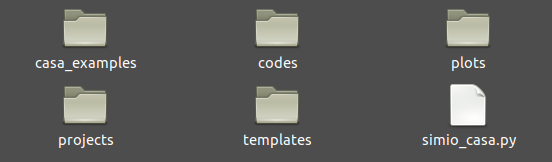

## Step 2: Include your template

Go into the **templates/** folder. Add to your *SIMIO* the template that will generate your synthetic observation. *SIMIO* has HD163296 from DSHARP as default template, and you can download others from this [page](https://www.nicolaskurtovic.com/simio/templates).

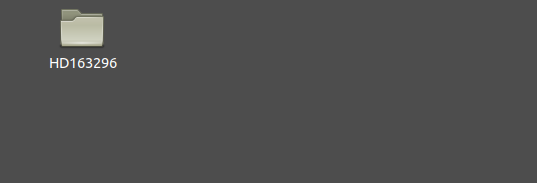

## Step 3: Create your project

Create a folder with the name of your project in the folder **projects/**. In this example, our project will be named "*SolarS_HD163296*", since we want to generate an observation of how the Solar System would look like if it had been observed by DSHARP at the distance and geometry of HD163296. You can use any name you want for this folder.

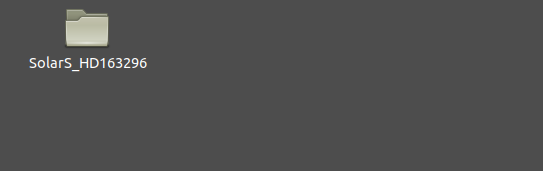

## Step 4: Prepare your project

Go inside your project folder, in this example we are inside the folder **SolarS_HD163296/**. Create the folders "*images*", "*msfiles*", "*uvtables*", and leave them empty. Add your radiative transfer image either in "*.out*" format (standard output format from [RADMC3D](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/)), or "*.npy*" format. In this example, our radiative transfer image is "*image_1300micron.out*".

The folders you just created will be used to store:
- **images**: The fits files generated with SIMIO will be stored in that folder. Check it after running the code.
- **msfiles**: Your synthetic observation will have its own measurement file, where the visibilities are stored. You will be able to find that file in this folder.
- **uvtables**: The visibilities will also be given in ".txt" format, which you can further use to analyze with other tools, such as [frank](https://discsim.github.io/frank/index.html) or [galario](https://mtazzari.github.io/galario/index.html). The visibility table will be written inside this folder.

## Step 5: Run SIMIO

Go back to the initial *SIMIO* folder. Open simio_casa.py and open CASA5.6.2 in a terminal.

The first part of the code will import all the necessary python packages, and sets the path to the simio folder.

```python
# Import needed python packages
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Get the current directory path
current_dir = os.getcwd()+'/'
```

The second part is needed to load the *SIMIO* functions. Each subcode needs functions from the previous, and so it is necessary to execute them in the correct order.

You should not need to change anything in the import and execute functions blocks.

```python
# Import the analysis utils functions
sys.path.append(current_dir+'codes/analysis_scripts/')
import analysisUtils as au


# Import the simio object
execfile(current_dir+'codes/simio_obj.py')
# Import functions for uv-handling
execfile(current_dir+'codes/simio_ms2ascii.py')
# Import functions for imaging
execfile(current_dir+'codes/simio_clean.py')
```

Create your *simio_object*, which is the basic object of the *SIMIO* package. This object will contain all the needed information to generate your synthetic observation.
- **object_name**: Write the name of your project, which you created in step 3 and 4.
- **im_file_name**: Name of your radiative transfer image, including the format.
- **template**: Name of the template you want to mimic. In this example HD163296.
- **use_tempgeom**: Set to True if you want SIMIO to incline and rotate your image with the inclination and position angle of the template, under the assumption that your input is face-on. If your image already has the geometry that you desire, and you do not want SIMIO to apply any geometric change, then set to False.

```python
###########################
# Solar System as HD163296
###########################

# Create a simio object.
simobj = simio_object(object_name  = 'SolarS_HD163296', 
                      im_file_name = 'image_1300micron.out', 
                      template     = 'HD163296', 
                      use_tempgeom = True)
```

The function *get_mod_ms* will take your image and generate the *measurement set* (which is the object that contains all the information of an ALMA observation), as if it had been observed at the location of your template. As an output in the code, you will receive the path to the *measurement set* in the variable *mod_ms*.

```python
# Create the measurement file of your simio object
# Can take several minutes
mod_ms = get_mod_ms(simobj)
```

Create the masks to [CLEAN](https://casa.nrao.edu/docs/taskref/tclean-task.html) the synthetic observation, and generate the images. This masks will be loaded into the *simobj*, and also returned as a string. They will have the standard of [CASA Regions](https://casaguides.nrao.edu/index.php/CASA_Region_Format).
- **mask_obj**: An elliptical mask with the geometry of the template. You can set the semi-major axis of the ellipse in units of arcsec. 
- **mask_res**: Generates an annulus mask, that will be used to calculate the background properties of your image.

```python
# Create Masks
mask_obj = simobj.get_mask(mask_semimajor=0.65) # in arcsec
mask_res = simobj.get_residual_mask()
```

Your synthetic observation has already been generated, but now we need to generate the images. The function *easy_mod_tclean* is a wrapper of the function *tclean* and *simobj*, which runs the CLEAN algorithm over your generated observation.

Set *interactive* to *True* to see if the mask includes all the emission. Press the green arrow to start a cycle of the cleaning process, or alternatively press the blue arrow and wait until its done.

Depending on your computer, and template, this step can take from few minutes to an hour. Be patient.

## Step 6: Check the results

Go back to the project folder. After executing *get_mod_ms*, you will find the ms file and the visibilities table in their respective folders (the ones you created in step 4). After executing *easy_mod_tclean*, you will get the products in the images folder.

The images will be named by your project name, plus a sufix. Each image is:
- **project_im.fits**: Beam convolved image, with the JvM correction ([Czekala et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJS..257....2C/abstract)). This how your source would look if it had been observed by ALMA with the same observational setup as the template.
- **project_im_model.fits**: The model image, generated by the CLEAN algorithm as a description of the visibilities of your source in the sky plane.
- **project_im_noJvM.fits**: Beam convolved image, without the JvM correction.
- **project_im_psf.fits**: The PSF of the observation.
- **project_im_residual.fits**: The residuals of the CLEAN algorithm. This residuals will be very structured, as the generated ms file does not contain noise. This residuals, however, should be very small in total flux.

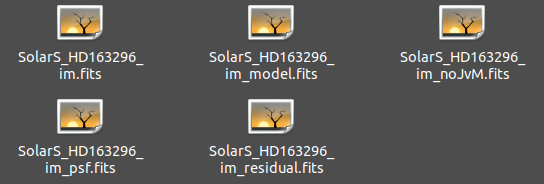